In [79]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from cebra import CEBRA
from sklearn.model_selection import train_test_split
import os
import tempfile
from pathlib import Path
from datetime import datetime
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
import pandas as pd

rats = ['achilles', 'buddy', 'cicero', 'gatsby']

datasets = {}

train_data = {}

valid_data = {}

train_label = {}

valid_label = {}

for name in rats:
    datasets[name] = cebra.datasets.hippocampus.SingleRatDataset(name=name, root='data', download=True)


    split_idx = int(0.8 * len(datasets[name].neural))
    train_data[name] = datasets[name].neural[:split_idx]
    valid_data[name] = datasets[name].neural[split_idx:]

    train_label[name] = datasets[name].continuous_index.numpy()[:split_idx]
    valid_label[name] = datasets[name].continuous_index.numpy()[split_idx:]
    
    
params_grid = dict(
    output_dimension=[8, 16, 32, 64],
    model_architecture=['offset10-model'],
    time_offsets=[5],
    temperature_mode='constant',
    temperature=[0.1],
    max_iterations=[2000],
    num_hidden_units=[32, 64],
    device='cuda_if_available',
    distance = ["cosine"],
    batch_size = 256,
    learning_rate = [1e-3, 5e-3],
    verbose=True
)
grid_search = cebra.grid_search.GridSearch()
models, params = grid_search.generate_models(params=params_grid)
    



    
    


In [80]:
models, parameter_grid = cebra.grid_search.GridSearch().load(dir="final_models")

In [84]:
models

{'output_dimension_8_achilles': CEBRA(batch_size=256, learning_rate=0.001, max_iterations=2000,
       model_architecture='offset10-model', num_hidden_units=64, temperature=0.1,
       time_offsets=5, verbose=True),
 'output_dimension_16_achilles': CEBRA(batch_size=256, learning_rate=0.001, max_iterations=2000,
       model_architecture='offset10-model', num_hidden_units=64,
       output_dimension=16, temperature=0.1, time_offsets=5, verbose=True),
 'output_dimension_32_achilles': CEBRA(batch_size=256, learning_rate=0.001, max_iterations=2000,
       model_architecture='offset10-model', num_hidden_units=64,
       output_dimension=32, temperature=0.1, time_offsets=5, verbose=True),
 'output_dimension_64_achilles': CEBRA(batch_size=256, learning_rate=0.001, max_iterations=2000,
       model_architecture='offset10-model', num_hidden_units=64,
       output_dimension=64, temperature=0.1, time_offsets=5, verbose=True),
 'output_dimension_8_buddy': CEBRA(batch_size=256, learning_rate=0.001

In [90]:
list(models.keys())[0].split('_')[-1]

'achilles'

In [ ]:
grid_search.fit_models(train_data, params=params_grid, models_dir="saved_models")

pos: -9.0660 neg:  10.1103 total:  1.0443 temperature:  0.1000: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.93it/s]
pos: -8.4394 neg:  8.6194 total:  0.1801 temperature:  0.1000: 100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.76it/s]
pos: -8.1001 neg:  8.1978 total:  0.0978 temperature:  0.1000: 100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.89it/s]
pos: -8.1076 neg:  8.1853 total:  0.0777 temperature:  0.1000: 100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.78it/s]
pos: -9.3990 neg:  10.0895 total:  0.6905 temperature:  0.1000: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.06it/s]
pos: -8.8367 neg:  8.4701 total: -0.3666 temperature:  0.1000: 100%|███████████████████████████

In [7]:
os.getcwd()

'/Users/arjun/cse599/interpretable-neural-embeddings'

In [8]:
models, parameter_grid = cebra.grid_search.GridSearch().load(dir="saved_models")

In [26]:
models_separated = {}
for name in rats:
    models_separated[name] = []
    for model in models:
        if not model.endswith(name):
            continue
        models_separated[name].append(models[model])

In [54]:
models['learning_rate_0.001_num_hidden_units_32_output_dimension_8'].learning_rate

0.001

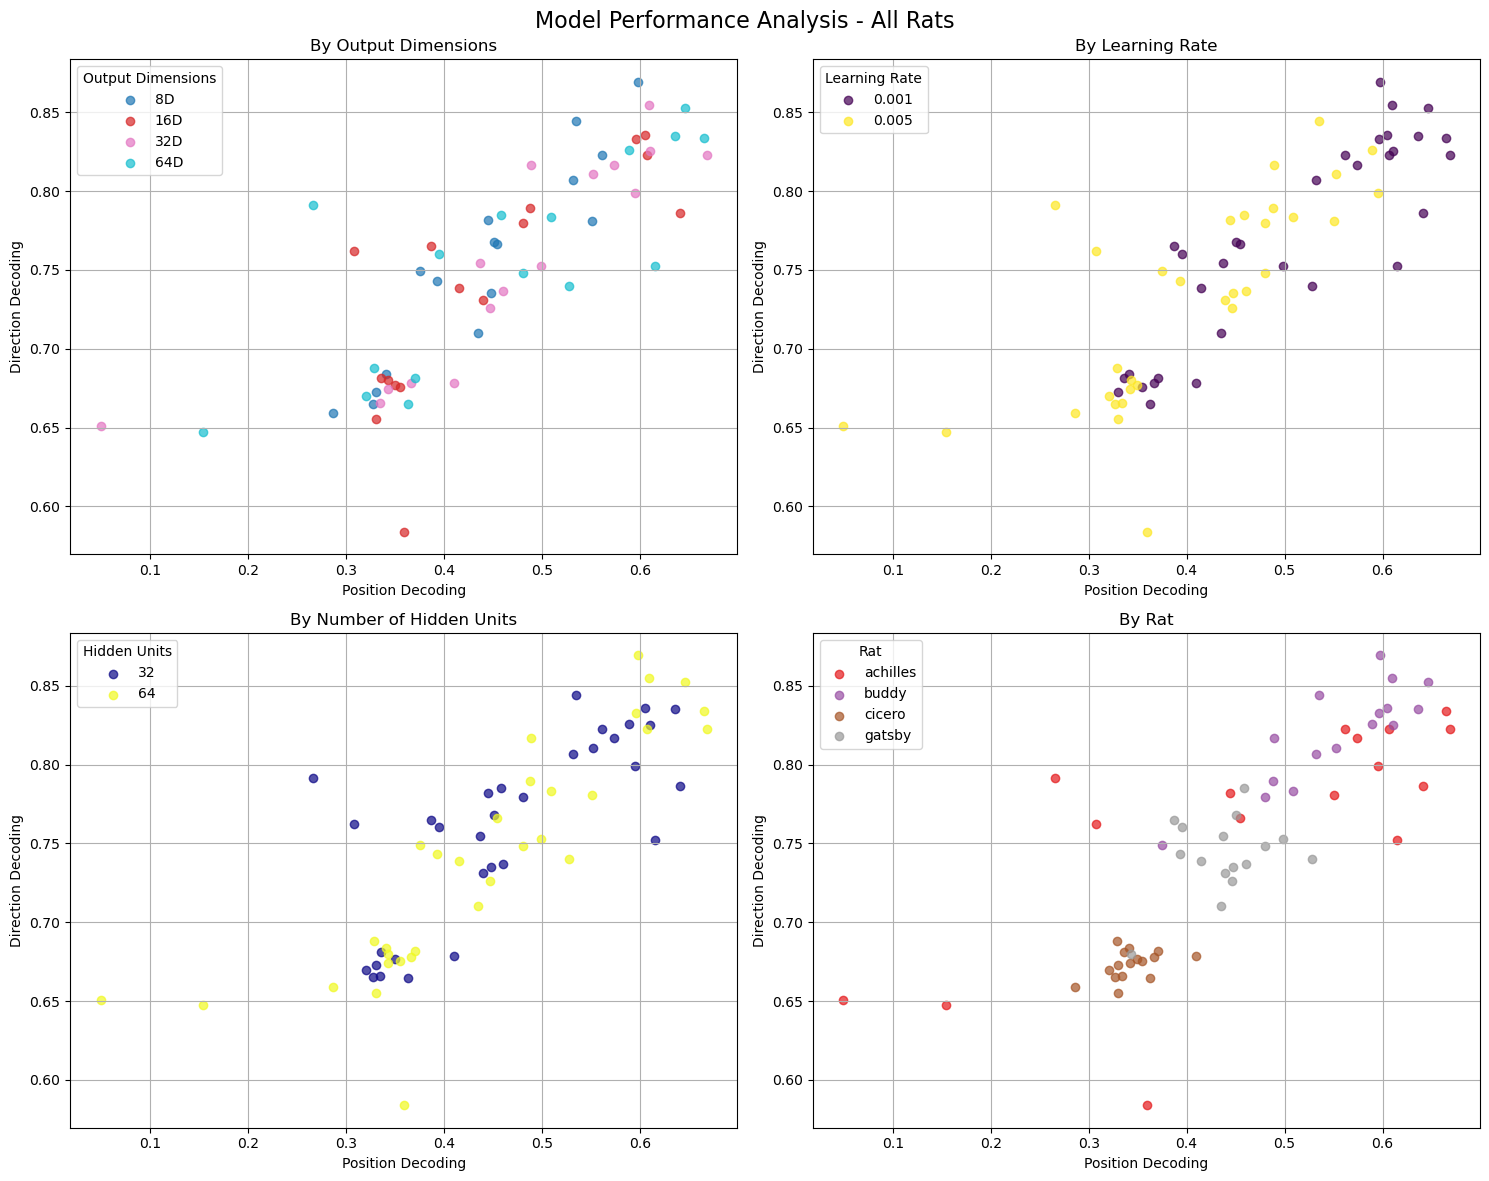

In [77]:
dfs = []
all_r2 = []
all_acc = []
all_output_dims = []
all_learning_rates = []
all_num_hidden = []
all_rat_names = []

for name in rats:
    r2 = []
    acc = []
    output_dims = []
    learning_rates = []
    num_hidden = []
    
    for curr_model in models_separated[name]:  
        curr_train_embedding = curr_model.transform(train_data[name])
        curr_valid_embedding = curr_model.transform(valid_data[name])
        
        y_train_pos = train_label[name][:, 0]
        y_valid_pos = valid_label[name][:, 0]
        reg = Ridge(alpha=1.0)
        reg.fit(curr_train_embedding, y_train_pos)
        pos_pred = reg.predict(curr_valid_embedding)
        pos_r2 = r2_score(y_valid_pos, pos_pred)
        y_train_dir = (train_label[name][:, 2] > train_label[name][:, 1]).astype(int)
        y_valid_dir = (valid_label[name][:, 2] > valid_label[name][:, 1]).astype(int)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(curr_train_embedding, y_train_dir)
        dir_pred = clf.predict(curr_valid_embedding)
        dir_acc = accuracy_score(y_valid_dir, dir_pred)
        
        r2.append(pos_r2)
        acc.append(dir_acc)
        output_dims.append(curr_model.output_dimension)
        learning_rates.append(curr_model.learning_rate)
        num_hidden.append(curr_model.num_hidden_units)
    
    all_r2.extend(r2)
    all_acc.extend(acc)
    all_output_dims.extend(output_dims)
    all_learning_rates.extend(learning_rates)
    all_num_hidden.extend(num_hidden)
    all_rat_names.extend([name] * len(r2))
    
    df = pd.DataFrame({
        'r2': r2, 
        'accuracy': acc, 
        'output_dimensions': output_dims,
        'learning_rate': learning_rates,
        'num_hidden_units': num_hidden,
        'rat_name': [name] * len(r2)
    })
    dfs.append(df)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Analysis - All Rats', fontsize=16)

ax1 = axes[0, 0]
unique_dims = sorted(set(all_output_dims))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_dims)))
color_map = dict(zip(unique_dims, colors))
for dim in unique_dims:
    mask = np.array(all_output_dims) == dim
    ax1.scatter(np.array(all_r2)[mask], np.array(all_acc)[mask], 
               c=[color_map[dim]], label=f'{dim}D', alpha=0.7)
ax1.legend(title='Output Dimensions')
ax1.set_xlabel("Position Decoding")
ax1.set_ylabel("Direction Decoding")
ax1.set_title("By Output Dimensions")
ax1.grid(True)

ax2 = axes[0, 1]
unique_lr = sorted(set(all_learning_rates))
colors_lr = plt.cm.viridis(np.linspace(0, 1, len(unique_lr)))
color_map_lr = dict(zip(unique_lr, colors_lr))
for lr in unique_lr:
    mask = np.array(all_learning_rates) == lr
    ax2.scatter(np.array(all_r2)[mask], np.array(all_acc)[mask], 
               c=[color_map_lr[lr]], label=f'{lr}', alpha=0.7)
ax2.legend(title='Learning Rate')
ax2.set_xlabel("Position Decoding")
ax2.set_ylabel("Direction Decoding")
ax2.set_title("By Learning Rate")
ax2.grid(True)

ax3 = axes[1, 0]
unique_hidden = sorted(set(all_num_hidden))
colors_hidden = plt.cm.plasma(np.linspace(0, 1, len(unique_hidden)))
color_map_hidden = dict(zip(unique_hidden, colors_hidden))
for hidden in unique_hidden:
    mask = np.array(all_num_hidden) == hidden
    ax3.scatter(np.array(all_r2)[mask], np.array(all_acc)[mask], 
               c=[color_map_hidden[hidden]], label=f'{hidden}', alpha=0.7)
ax3.legend(title='Hidden Units')
ax3.set_xlabel("Position Decoding")
ax3.set_ylabel("Direction Decoding")
ax3.set_title("By Number of Hidden Units")
ax3.grid(True)

ax4 = axes[1, 1]
unique_rats = sorted(set(all_rat_names))
colors_rats = plt.cm.Set1(np.linspace(0, 1, len(unique_rats)))
color_map_rats = dict(zip(unique_rats, colors_rats))
for rat in unique_rats:
    mask = np.array(all_rat_names) == rat
    ax4.scatter(np.array(all_r2)[mask], np.array(all_acc)[mask], 
               c=[color_map_rats[rat]], label=f'{rat}', alpha=0.7)
ax4.legend(title='Rat')
ax4.set_xlabel("Position Decoding")
ax4.set_ylabel("Direction Decoding")
ax4.set_title("By Rat")
ax4.grid(True)

plt.tight_layout()
plt.show()

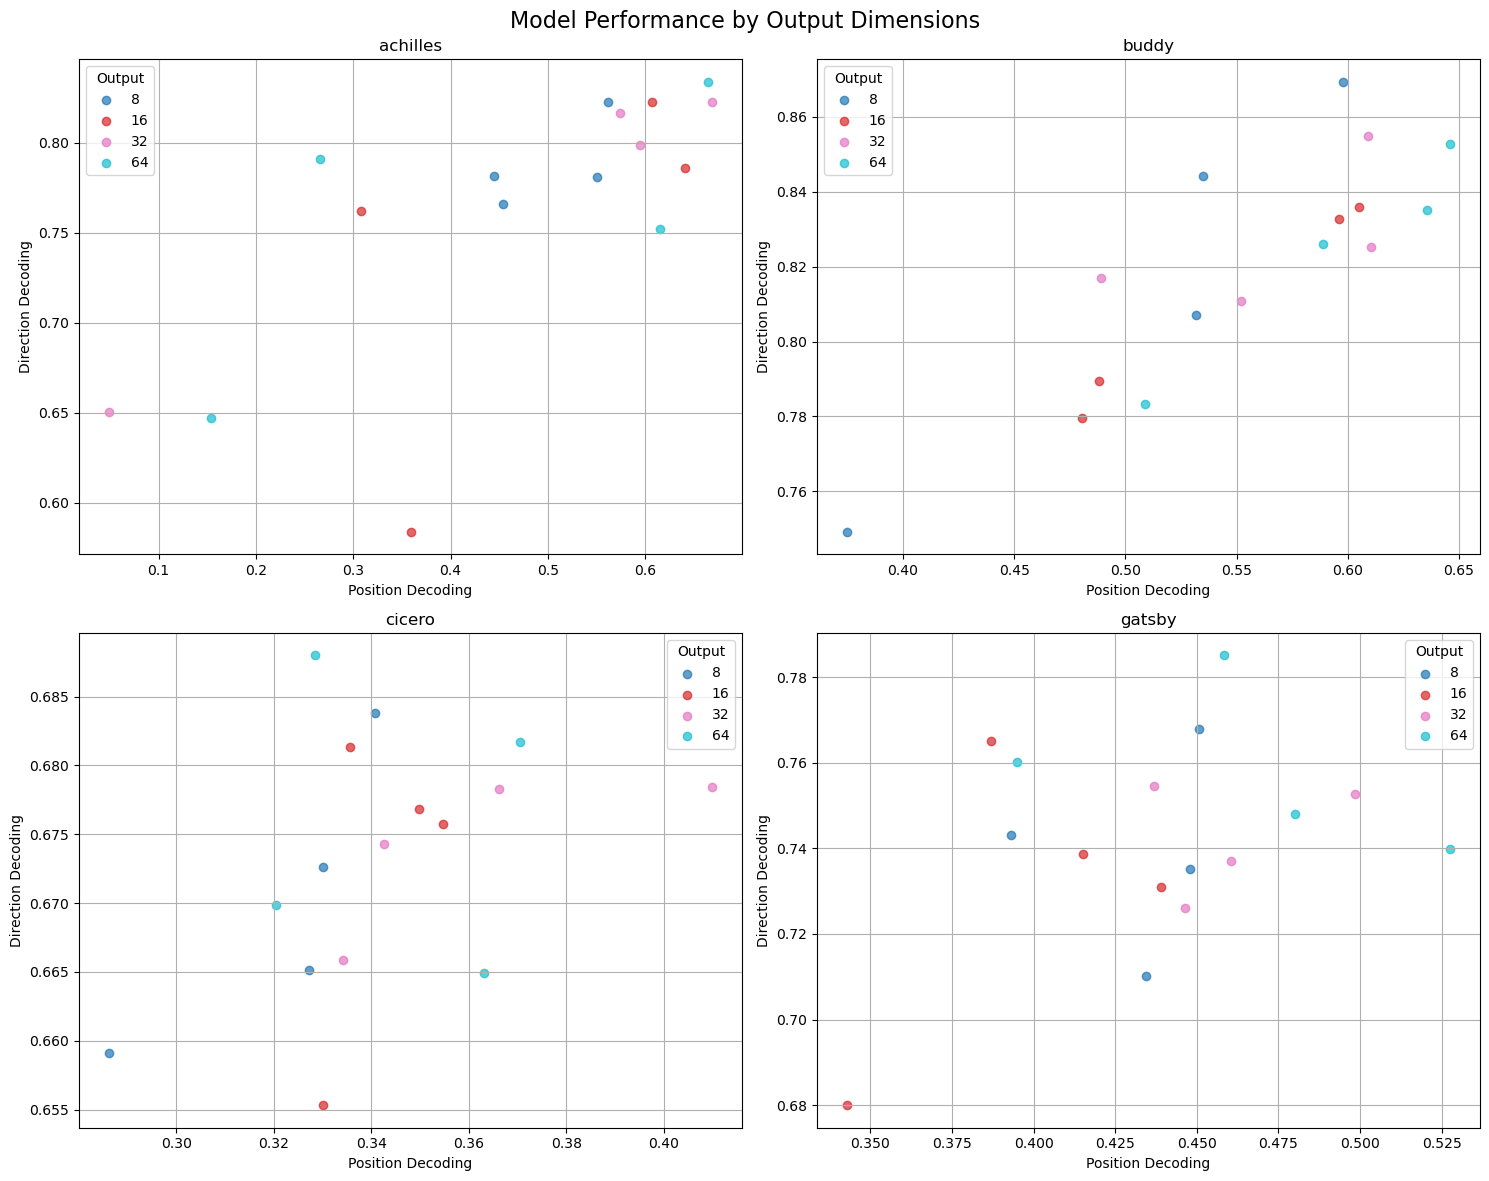

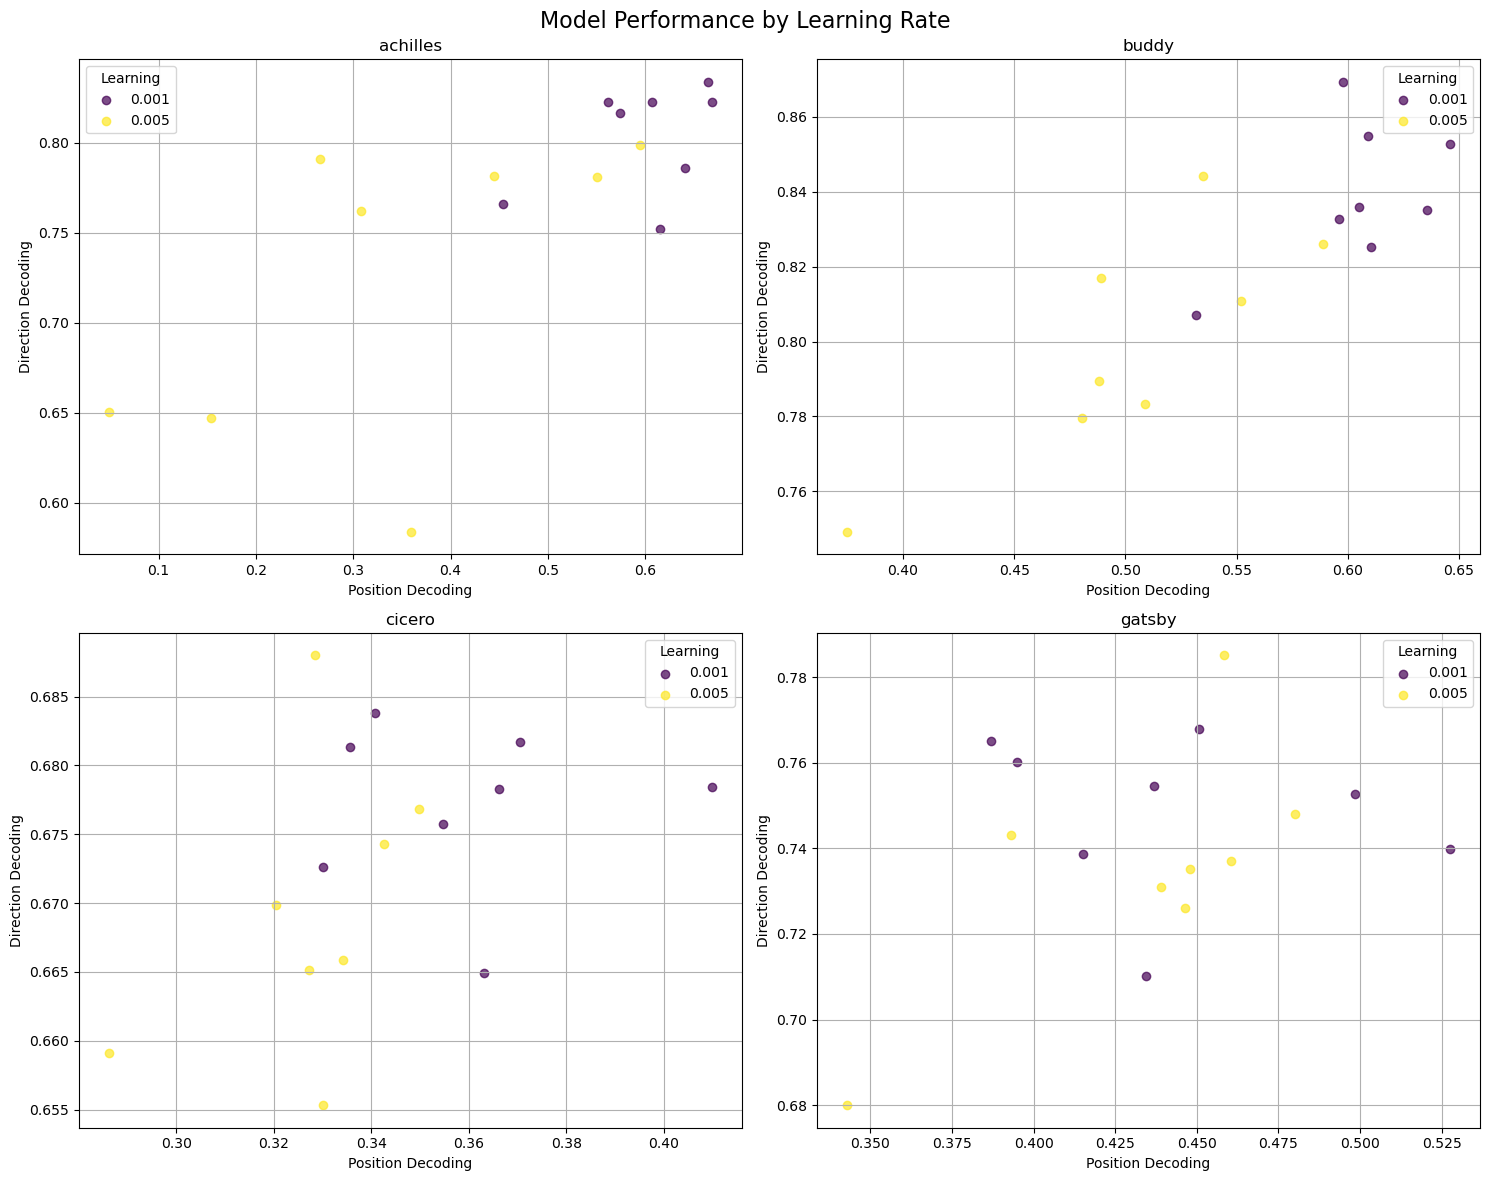

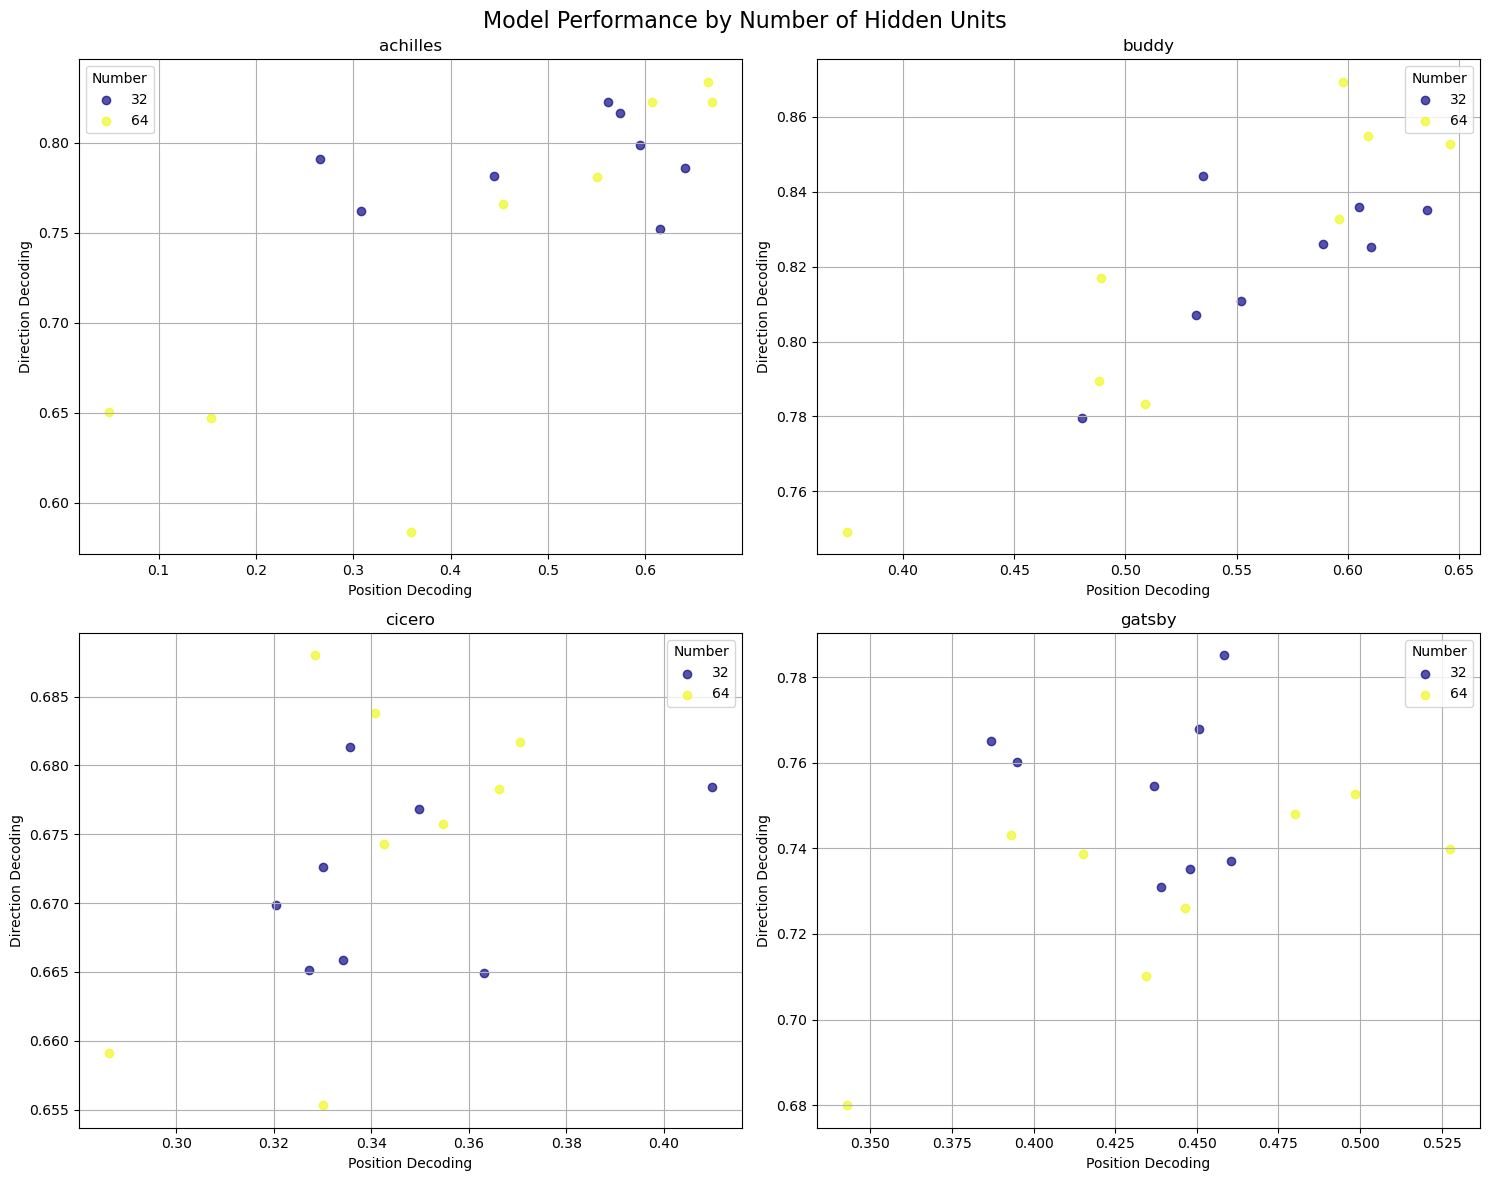

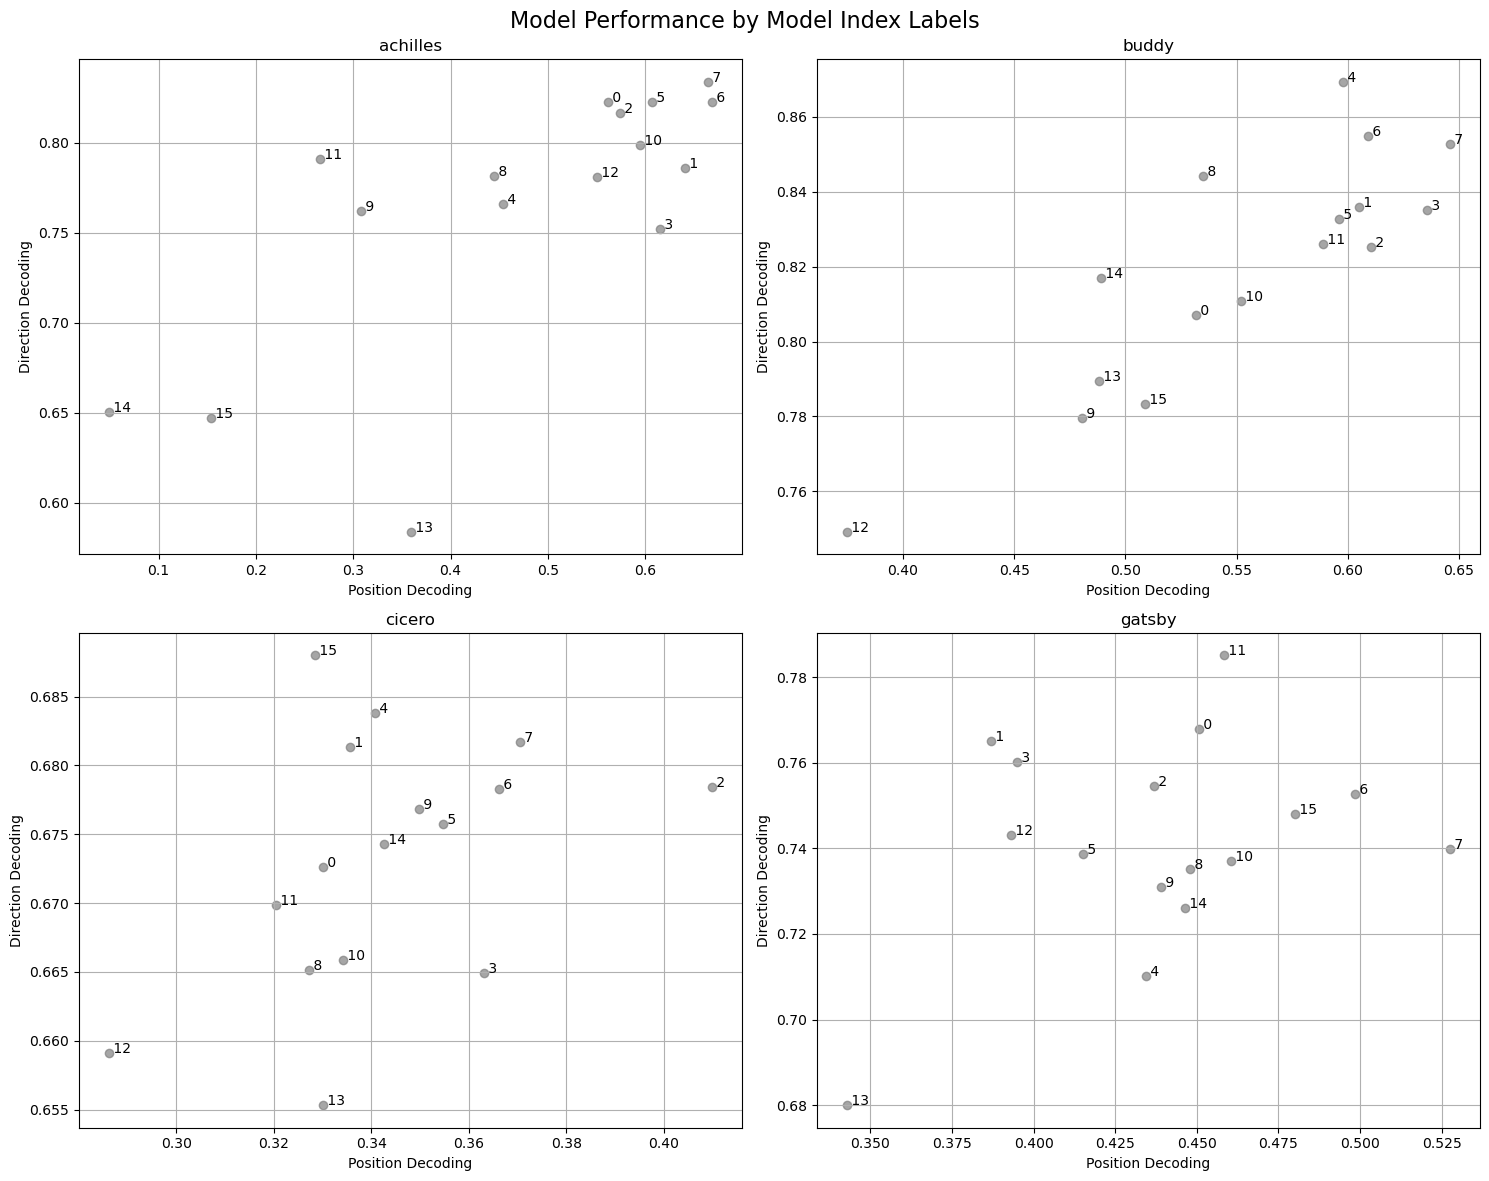

In [78]:
dfs = []
all_data = {}

for name in rats:
    r2 = []
    acc = []
    output_dims = []
    learning_rates = []
    num_hidden = []
    
    for curr_model in models_separated[name]:  
        curr_train_embedding = curr_model.transform(train_data[name])
        curr_valid_embedding = curr_model.transform(valid_data[name])
        
        y_train_pos = train_label[name][:, 0]
        y_valid_pos = valid_label[name][:, 0]
        reg = Ridge(alpha=1.0)
        reg.fit(curr_train_embedding, y_train_pos)
        pos_pred = reg.predict(curr_valid_embedding)
        pos_r2 = r2_score(y_valid_pos, pos_pred)
        y_train_dir = (train_label[name][:, 2] > train_label[name][:, 1]).astype(int)
        y_valid_dir = (valid_label[name][:, 2] > valid_label[name][:, 1]).astype(int)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(curr_train_embedding, y_train_dir)
        dir_pred = clf.predict(curr_valid_embedding)
        dir_acc = accuracy_score(y_valid_dir, dir_pred)
        
        r2.append(pos_r2)
        acc.append(dir_acc)
        output_dims.append(curr_model.output_dimension)
        learning_rates.append(curr_model.learning_rate)
        num_hidden.append(curr_model.num_hidden_units)
    
    all_data[name] = {
        'r2': r2,
        'acc': acc,
        'output_dims': output_dims,
        'learning_rates': learning_rates,
        'num_hidden': num_hidden
    }
    
    df = pd.DataFrame({
        'r2': r2, 
        'accuracy': acc, 
        'output_dimensions': output_dims,
        'learning_rate': learning_rates,
        'num_hidden_units': num_hidden
    })
    dfs.append(df)

parameters = ['output_dims', 'learning_rates', 'num_hidden', 'annotations']
parameter_titles = ['Output Dimensions', 'Learning Rate', 'Number of Hidden Units', 'Model Index Labels']
colormaps = ['tab10', 'viridis', 'plasma', 'gray']

for param_idx, (param, title, cmap) in enumerate(zip(parameters, parameter_titles, colormaps)):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Model Performance by {title}', fontsize=16)
    
    for rat_idx, name in enumerate(rats):
        ax = axes[rat_idx // 2, rat_idx % 2]
        
        r2_data = all_data[name]['r2']
        acc_data = all_data[name]['acc']
        
        if param == 'annotations':
            ax.scatter(r2_data, acc_data, alpha=0.7, c='gray')
            for i, (r2_val, acc_val) in enumerate(zip(r2_data, acc_data)):
                ax.annotate(f' {i}', (r2_val, acc_val))
        else:
            param_data = all_data[name][param]
            unique_vals = sorted(set(param_data))
            
            if cmap == 'gray':
                colors = plt.cm.Set1(np.linspace(0, 1, len(unique_vals)))
            else:
                colors = getattr(plt.cm, cmap)(np.linspace(0, 1, len(unique_vals)))
            
            color_map = dict(zip(unique_vals, colors))
            
            for val in unique_vals:
                mask = np.array(param_data) == val
                ax.scatter(np.array(r2_data)[mask], np.array(acc_data)[mask], 
                          c=[color_map[val]], label=f'{val}', alpha=0.7)
            
            ax.legend(title=title.split()[0])
        
        ax.set_xlabel("Position Decoding")
        ax.set_ylabel("Direction Decoding")
        ax.set_title(f'{name}')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()